Notebook para generar modelos para predecir la cantidad de clientes por los principale ID_Entidad_Fed 

In [1]:
# Python
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
import numpy as np
import joblib

d:\claseMreporeto\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar el dataset (Reservaciones)

In [3]:
ocupaciones = pd.read_excel("../data/ocupaciones_time_series_by_entidad.xlsx").sort_values(
    "Fecha_hoy",
    ascending=True,
)

ocupaciones.head()

,Fecha_hoy,ID_Entidad_Fed,ing_hab,cto_noc,ADR,num_men,num_adu,TREVPEC,tasa_ocupacion
0,2020-11-01,Otro,8.154449e+04,36.0,50214.973902,28.0,74.0,2.703952e+05,0.010033
1,2020-11-01,173,1.561952e+06,800.0,760723.172391,352.0,1598.0,4.289819e+06,0.222965
2,2020-11-01,294,4.513085e+04,20.0,45130.854144,6.0,38.0,2.596194e+05,0.005574
3,2020-11-01,48,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000
4,2020-11-01,5,1.539729e+04,6.0,15397.288134,6.0,12.0,8.352593e+04,0.001672


In [4]:
ocupaciones.shape[0]/6

1507.0

# Preprocesamiento

### Renombrar el nombre de las columnas para usar el modelo prophet

In [5]:
# Example: Load data
# Select only 'ID_Entidad_Fed' = 173
reservaciones = ocupaciones[ocupaciones['ID_Entidad_Fed'] == '173'].copy()
print(reservaciones.shape)
df = reservaciones[['Fecha_hoy','num_adu']]
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df['cap'] = 400000.0  # upper bound
df['floor'] = 0.0  # optional lower bound (default is 0)

(1507, 9)


C:\Users\angel\AppData\Local\Temp\ipykernel_29428\1560681344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\angel\AppData\Local\Temp\ipykernel_29428\1560681344.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cap'] = 400000.0  # upper bound
C:\Users\angel\AppData\Local\Temp\ipykernel_29428\1560681344.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Mostrar la serie de tiempo

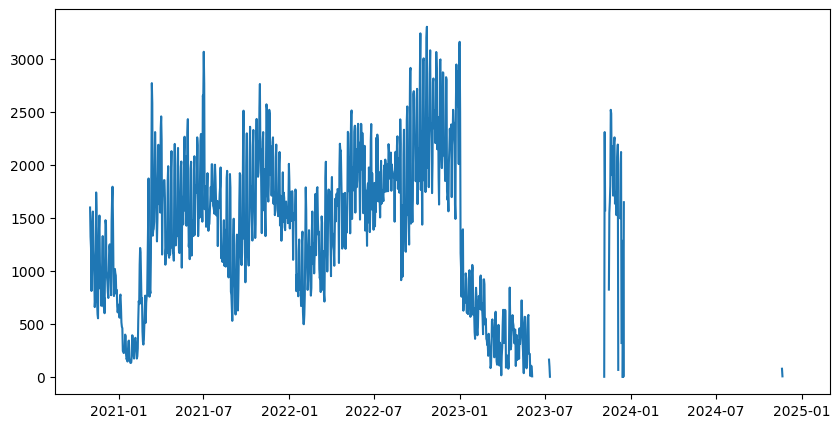

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual')

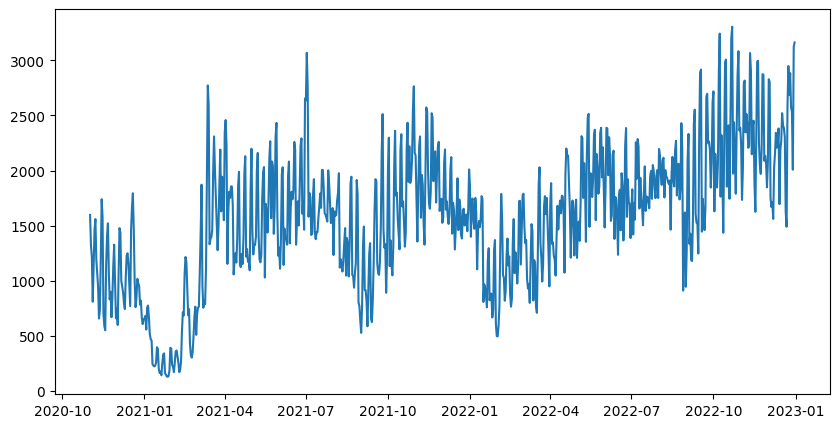

In [7]:
# Select df until 'Fecha_hoy' < '2023-01-01'
df= df[df['ds'] < '2023-01-01']
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual')

Parece no ser una serie estacionaria, posiblemente por la influencia de la pandemia de COVID-19

# Comprobar si se trata de una serie estacionaria

## Descomponer la serie de tiempo (TS) en sus distintas componentes

<Figure size 640x480 with 0 Axes>

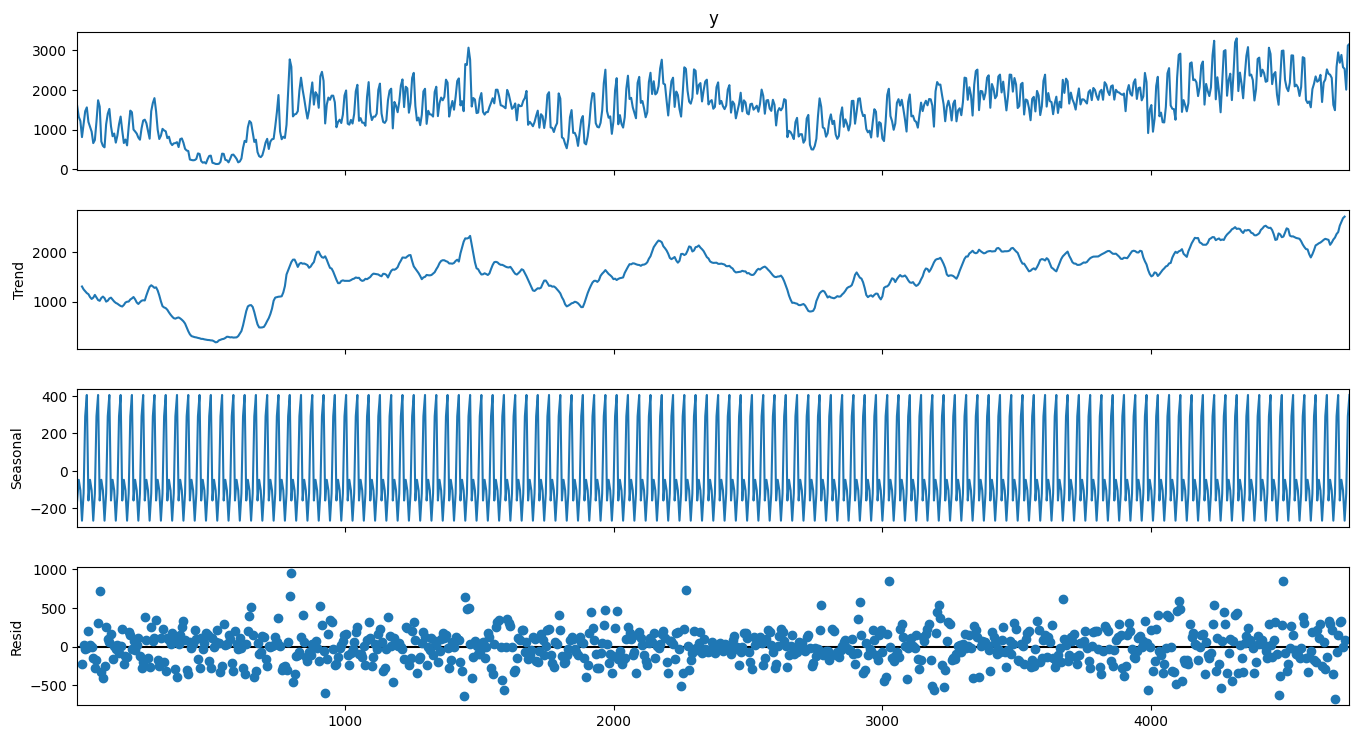

In [8]:
decomposition = seasonal_decompose(df['y'], period=7)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [9]:
data_trend = decomposition._trend
data_seasonal = decomposition._seasonal
data_ramdom = decomposition._resid

- La componente de tendencia parece decrecer de forma lineal, mientras que la estacional se repite de forma continua y los residuos parecen estar muy cercanos a cero

## Examen de estacionalidad: Componente ARIMA

---

Test estadistico:

1. Hipótesis nula:	Los datos son no estacionarios

2. Hipótesis alterna:	Los datos son estacionarios


Acción --> Rechaza H0 cuando el estadístico de prueba > valor crítico

In [10]:
def adfuller_w_decision(series_main_column):
    adf_test = adfuller(series_main_column)
    print('--------------------------------------------------------------------------------------')
    print('| ADF Statistic: %f' % adf_test[0])
    for key,value in adf_test[4].items():
        print(f'| Critical Value (Nivel de significancia {key}): ' + str(value))
    print('| p-value: %f' % adf_test[1])
    print('--------------------------------------------------------------------------------------')
    print('| Test a nivel de significancia 1%:')
    if adf_test[0] > adf_test[4]['5%']:
        print('| ')
        print('| No hay suficiente evidencia para rechazar H0. Los datos NO son estacionarios.')
        print('--------------------------------------------------------------------------------------')
    else:
        print('| ')
        print('| Hay evidencia para rechazar H0 y aceptar Ha. Los datos SI son estacionarios.')
        print('--------------------------------------------------------------------------------------')

adfuller_w_decision(df['y'])

--------------------------------------------------------------------------------------
| ADF Statistic: -1.887592
| Critical Value (Nivel de significancia 1%): -3.438882201132452
| Critical Value (Nivel de significancia 5%): -2.865305765357574
| Critical Value (Nivel de significancia 10%): -2.568775270215655
| p-value: 0.337921
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| No hay suficiente evidencia para rechazar H0. Los datos NO son estacionarios.
--------------------------------------------------------------------------------------


# Aplicar SARIMA

Encontrar parametros

## D y d

---

### d

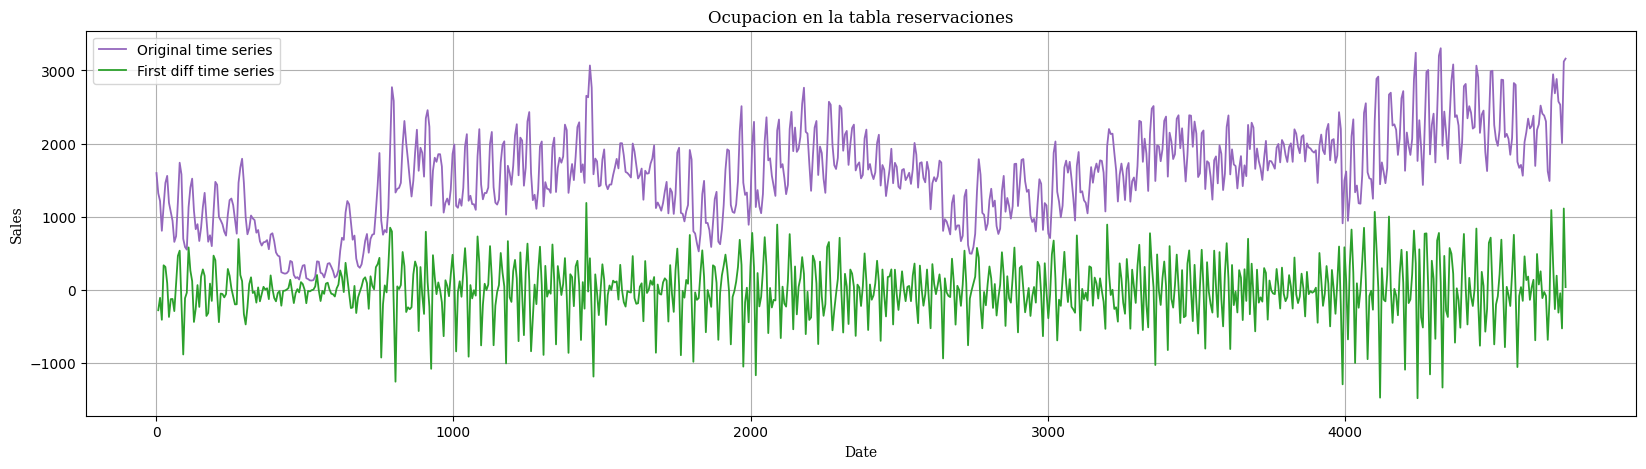

--------------------------------------------------------------------------------------
| ADF Statistic: -6.792121
| Critical Value (Nivel de significancia 1%): -3.4388933482333464
| Critical Value (Nivel de significancia 5%): -2.8653106782623574
| Critical Value (Nivel de significancia 10%): -2.5687778874376086
| p-value: 0.000000
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| Hay evidencia para rechazar H0 y aceptar Ha. Los datos SI son estacionarios.
--------------------------------------------------------------------------------------


In [11]:
first_diff = (df['y'] - df['y'].shift(1))[1:]

#Plot config
font_name = "Serif"

# Plot the time series
plt.figure(figsize=(20,5))
plt.plot(df['y'],linewidth=1.3, c='tab:purple', label = 'Original time series')
plt.plot(first_diff,linewidth=1.3, c='tab:green', label = 'First diff time series')
plt.title('Ocupacion en la tabla reservaciones', fontname=font_name)
plt.xlabel('Date', fontname=font_name)
plt.ylabel('Sales', fontname=font_name)
plt.legend()
plt.grid()
plt.show()

#Applying ADF test on the first order differentiation of the time series
adfuller_w_decision(first_diff)

### Encontrar D, con la componente de estacionalidad

In [12]:
print(adfuller_w_decision(data_seasonal))

print('--------------------------------------------------------------------------------------')

print('Los datos de la componente estacional no son estacionarios, por lo que se procede a aplicar la diferenciacion de primer orden.')

print('--------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------
| ADF Statistic: -0.000000
| Critical Value (Nivel de significancia 1%): -3.438882201132452
| Critical Value (Nivel de significancia 5%): -2.865305765357574
| Critical Value (Nivel de significancia 10%): -2.568775270215655
| p-value: 0.958532
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| No hay suficiente evidencia para rechazar H0. Los datos NO son estacionarios.
--------------------------------------------------------------------------------------
None
--------------------------------------------------------------------------------------
Los datos de la componente estacional no son estacionarios, por lo que se procede a aplicar la diferenciacion de primer orden.
--------------------------------------------------------------------------------------


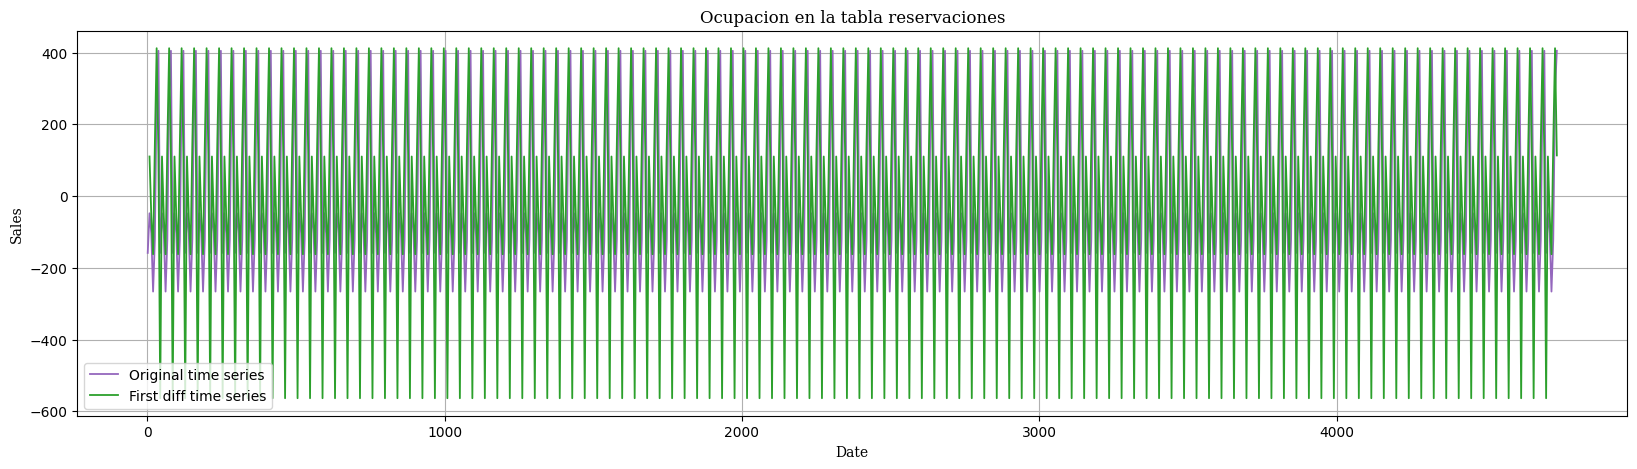

--------------------------------------------------------------------------------------
| ADF Statistic: -12904933393884612.000000
| Critical Value (Nivel de significancia 1%): -3.438750669890019
| Critical Value (Nivel de significancia 5%): -2.8652477937238703
| Critical Value (Nivel de significancia 10%): -2.56874438754281
| p-value: 0.000000
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| Hay evidencia para rechazar H0 y aceptar Ha. Los datos SI son estacionarios.
--------------------------------------------------------------------------------------


In [13]:
first_diff_s = (data_seasonal - data_seasonal.shift(1))[1:]

#Plot config
font_name = "Serif"

# Plot the time series
plt.figure(figsize=(20,5))
plt.plot(data_seasonal,linewidth=1.3, c='tab:purple', label = 'Original time series')
plt.plot(first_diff_s,linewidth=1.3, c='tab:green', label = 'First diff time series')
plt.title('Ocupacion en la tabla reservaciones', fontname=font_name)
plt.xlabel('Date', fontname=font_name)
plt.ylabel('Sales', fontname=font_name)
plt.legend()
plt.grid()
plt.show()

#Applying ADF test on the first order differentiation of the time series
adfuller_w_decision(first_diff_s)


### Resultados:

- D=1

- d=1

## P, Q y p,q

p = autocorrelación parcial

q = autocorrelación 

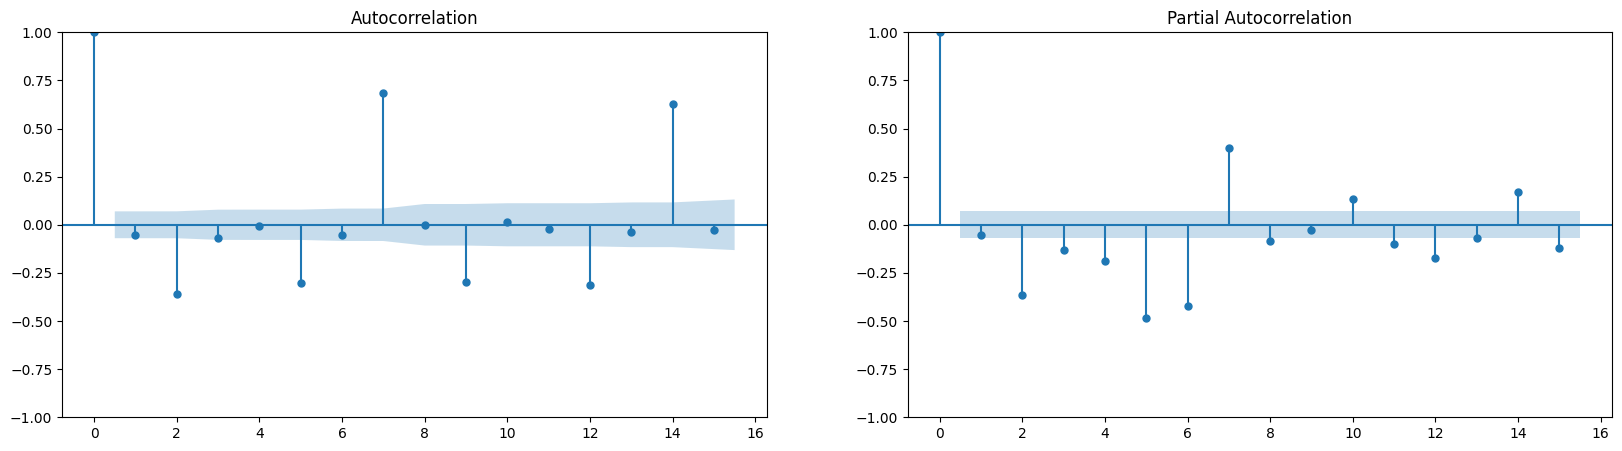

In [14]:
def autocorrelation_plots(series_main_column, lags):
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    plot_acf(series_main_column, lags=lags, ax=ax[0])
    plot_pacf(series_main_column, lags=lags, ax=ax[1])
    plt.show()

autocorrelation_plots(first_diff, 15)

Para la serie original desplazada usar `q=0 p=0`

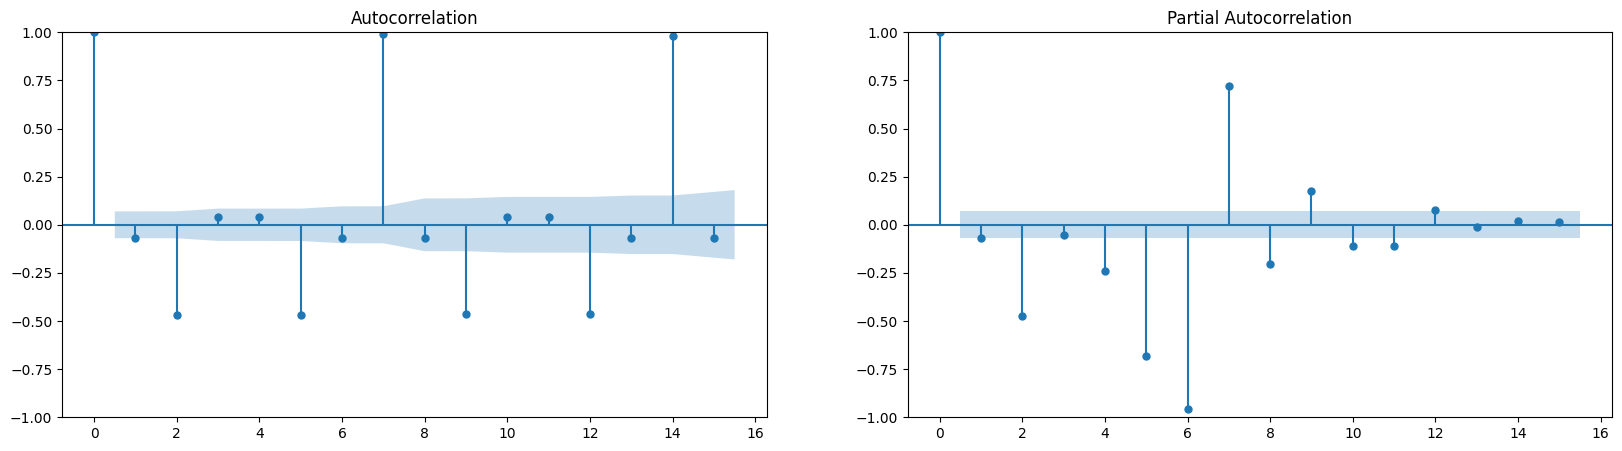

In [15]:
autocorrelation_plots(first_diff_s, 15)

Para la serie estacional usar `Q=3 P=3`

## Construccion del modelo

Train size: 632, Test size: 159


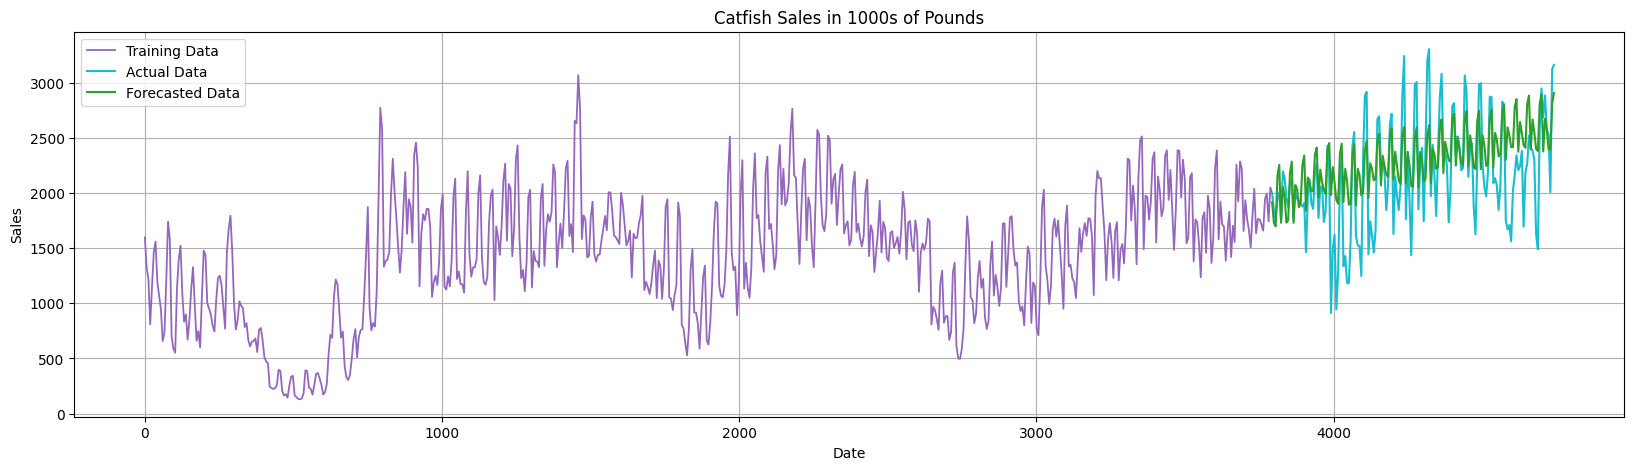

In [16]:
warnings.filterwarnings('ignore')
# Split the data into train and test
#train_size = int(len(data) * 0.8)
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]
print(f'Train size: {len(train)}, Test size: {len(test)}')

# Fit the ARIMA model on the training dataset
model_train = SARIMAX(train['y'], order=(0, 1, 0), seasonal_order = (3, 1, 3, 7))
model_train_fit = model_train.fit(disp=0)

# Forecast on the test dataset
test_forecast = model_train_fit.forecast(len(test))
test_forecast.index = test.index

#Plot config
font_name = "Serif"

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(20,5))
plt.plot(df[0:train_size+1]['y'],linewidth=1.3, c='tab:purple', label='Training Data')
plt.plot(test['y'], label='Actual Data', color='tab:cyan')
plt.plot(test_forecast, label='Forecasted Data', color='tab:green')
plt.title('Catfish Sales in 1000s of Pounds')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [17]:

residuals = test['y'] - test_forecast
rmse = mean_squared_error(test['y'], test_forecast)**0.5
r_2 = r2_score(test['y'], test_forecast)
print('R-squared:', r_2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['y'])),len(residuals)))

R-squared: 0.3660836371164914
Root Mean Squared Error (RMSE): 390.05175556525165
Mean Absolute Percent Error: 0.16805512119125485


El modelo SARIMA refleja un rendimiento positivo para la predicción de ocupación hotelera en el set de entrenamiento.

# Modelo `PROPHET`

---

Para comparar el rendimeinto de SARIMA se utilizará el modelo PROPHET desarrollado por un equipo de ingenieros de META

*Permite agregar días especiales*

In [18]:
mexican_holidays = pd.DataFrame({
    'holiday': [
        'New Year\'s Day', 'Constitution Day', 'Benito Juárez Day',
        'Labor Day', 'Independence Day', 'Revolution Day',
        'Christmas Day1', 'ChristmasDay2', 'ChristmasDay3', 'Christmas Day4', 'ChristmasDay5', 'ChristmasDay6',
        'Christmas Day7', 'ChristmasDay8', 'ChristmasDay9', 'Christmas Day10', 'ChristmasDay11',
          'Day of the Dead', 'Holy Thursday', 'Good Friday'
    ],
    'ds': pd.to_datetime([
        '2024-01-01',  # Año Nuevo
        '2024-02-05',  # Día de la Constitución (first Monday of Feb)
        '2024-03-18',  # Natalicio de Benito Juárez (observed)
        '2024-05-01',  # Día del Trabajo
        '2024-09-16',  # Día de la Independencia
        '2024-11-18',  # Día de la Revolución (observed)
        '2024-12-21',  # Navidad
        '2024-12-22',  # Navidad
        '2024-12-23',  # Navidad
        '2024-12-24',  # Navidad
        '2024-12-25',  # Navidad
        '2024-12-26',  # Navidad
        '2024-12-27',  # Navidad
        '2024-12-28',  # Navidad
        '2024-12-29',  # Navidad
        '2024-12-30',  # Navidad
        '2024-12-31',  # Navidad
        '2024-11-02',  # Día de Muertos
        '2024-03-28',  # Jueves Santo
        '2024-03-29',  # Viernes Santo
    ]),
    'lower_window': -2,
    'upper_window': 2
})

## Generar el modelo

## Entrenamiento

In [19]:
model = Prophet(growth='linear',holidays=mexican_holidays)
model.fit(train)

22:50:30 - cmdstanpy - INFO - Chain [1] start processing
22:50:31 - cmdstanpy - INFO - Chain [1] done processing


## Predicciones sobre el set de entrenamiento y métricas de rendimiento

In [20]:
future = test[['ds']]  # Use the actual dates from your test set
future['cap'] = 400000.0  # upper bound
future['floor'] = 0.0
forecast = model.predict(future)

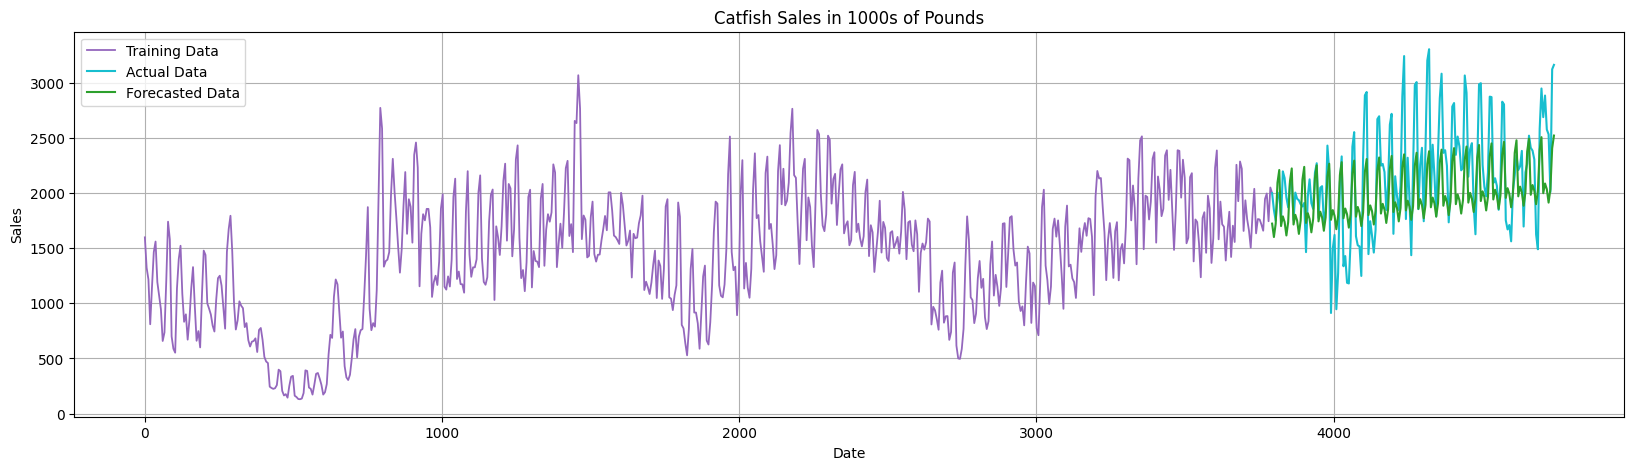

In [21]:
#Plot config
font_name = "Serif"

graph_forecast =pd.DataFrame({
    
    'yhat': forecast['yhat'],
})
graph_forecast.index = test.index

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(20,5))
plt.plot(df[0:train_size+1]['y'],linewidth=1.3, c='tab:purple', label='Training Data')
plt.plot(test['y'], label='Actual Data', color='tab:cyan')
plt.plot(graph_forecast, label='Forecasted Data', color='tab:green')
plt.title('Catfish Sales in 1000s of Pounds')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Compare predicted 'yhat' to actual 'y'
y_true = test['y'].values
y_pred = forecast['yhat'].values

residuals = y_true - y_pred
r_2 = r2_score(test['y'], test_forecast)
print('R-squared:', r_2)
rmse = mean_squared_error(test['y'], y_pred)**0.5
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['y'])),len(residuals)))


R-squared: 0.3660836371164914
Root Mean Squared Error (RMSE): 387.7297239125428
Mean Absolute Percent Error: 0.15095259979835776


# Conclusión

El modelo de PROPHET supera al de SARIMA en el RMSE, por lo que se usará como predicción. Parece ser que su capacidad de tener en cuenta el ruido y días festivos lo hace mejor para este problema

# Guardar el modelo

In [23]:
# Save the model
joblib.dump(model, '../models/prophet_model_numadu_173.pkl')

['../models/prophet_model_numadu_173.pkl']

# Modelos para las demás entidades federativas

In [27]:
# Example: Load data
# Select only 'ID_Entidad_Fed' = 173
estados= ocupaciones.value_counts('ID_Entidad_Fed').sort_values(ascending=False).head(5).index.to_list()
# Invert the list estados
estados = estados[::-1]
print(estados)


['5', '48', '294', '253', '173']


Processing state: 5
(1507, 9)
Train size: 632, Test size: 159


22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:36 - cmdstanpy - INFO - Chain [1] done processing


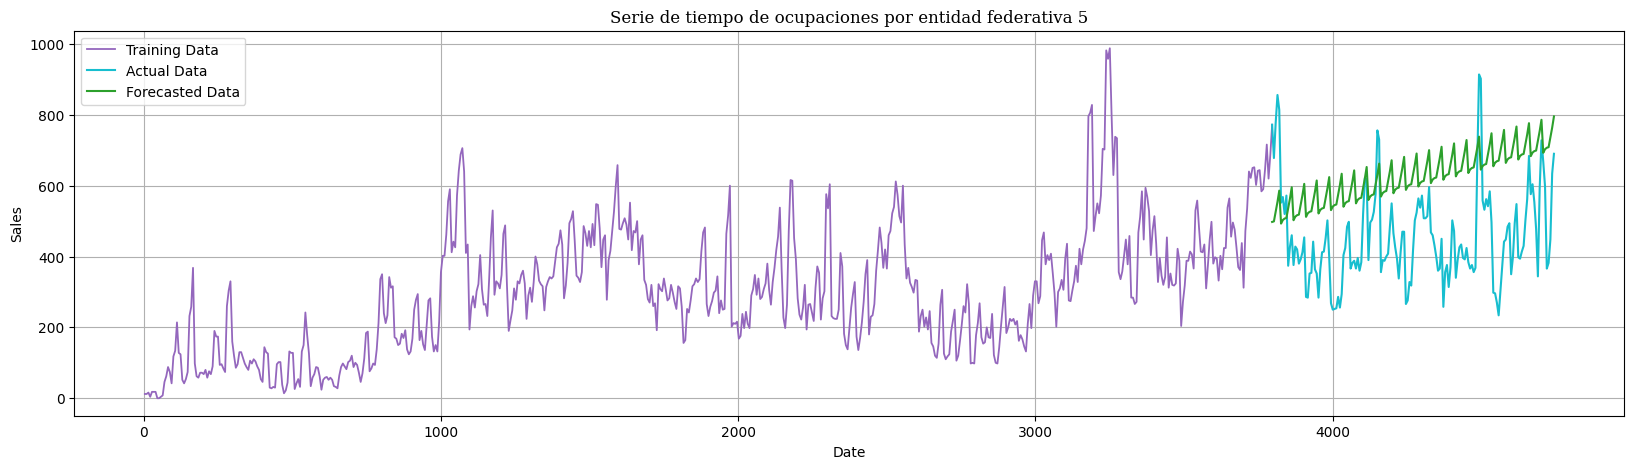

R-squared: -1.7051395277900427
Root Mean Squared Error (RMSE): 218.17600448580978
Mean Absolute Percent Error: 0.5084023727661915
Processing state: 48
(1507, 9)
Train size: 632, Test size: 159


22:51:38 - cmdstanpy - INFO - Chain [1] start processing
22:51:38 - cmdstanpy - INFO - Chain [1] done processing


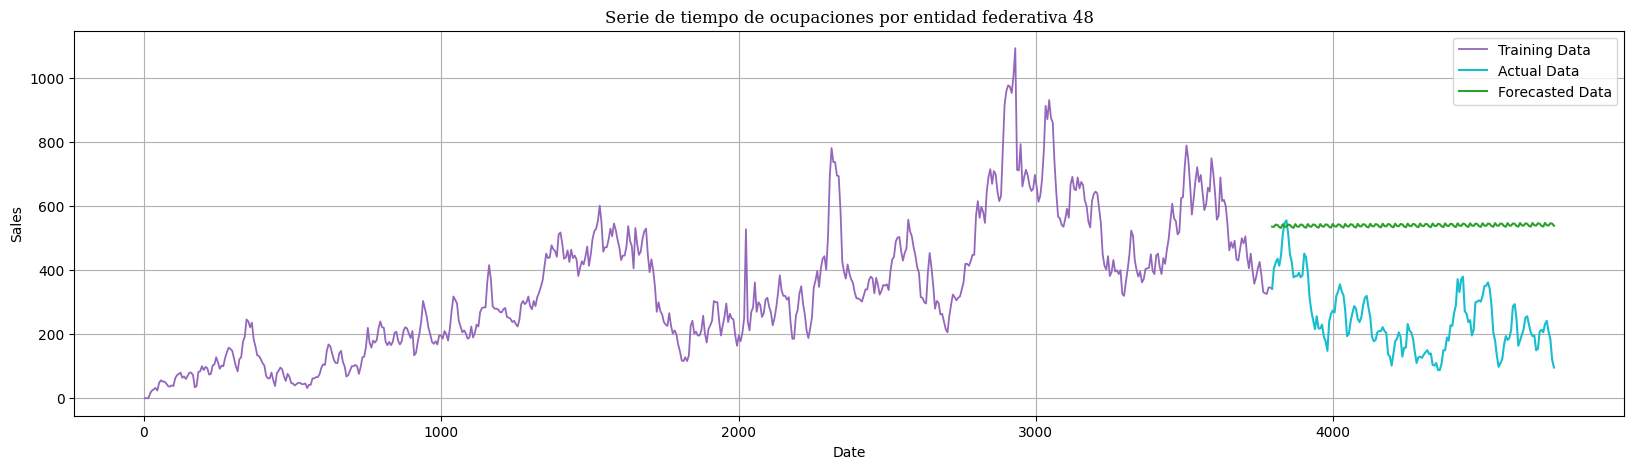

R-squared: -8.663643849094035
Root Mean Squared Error (RMSE): 311.5533752889503
Mean Absolute Percent Error: 1.6045194017048137
Processing state: 294
(1507, 9)
Train size: 632, Test size: 159


22:51:40 - cmdstanpy - INFO - Chain [1] start processing
22:51:40 - cmdstanpy - INFO - Chain [1] done processing


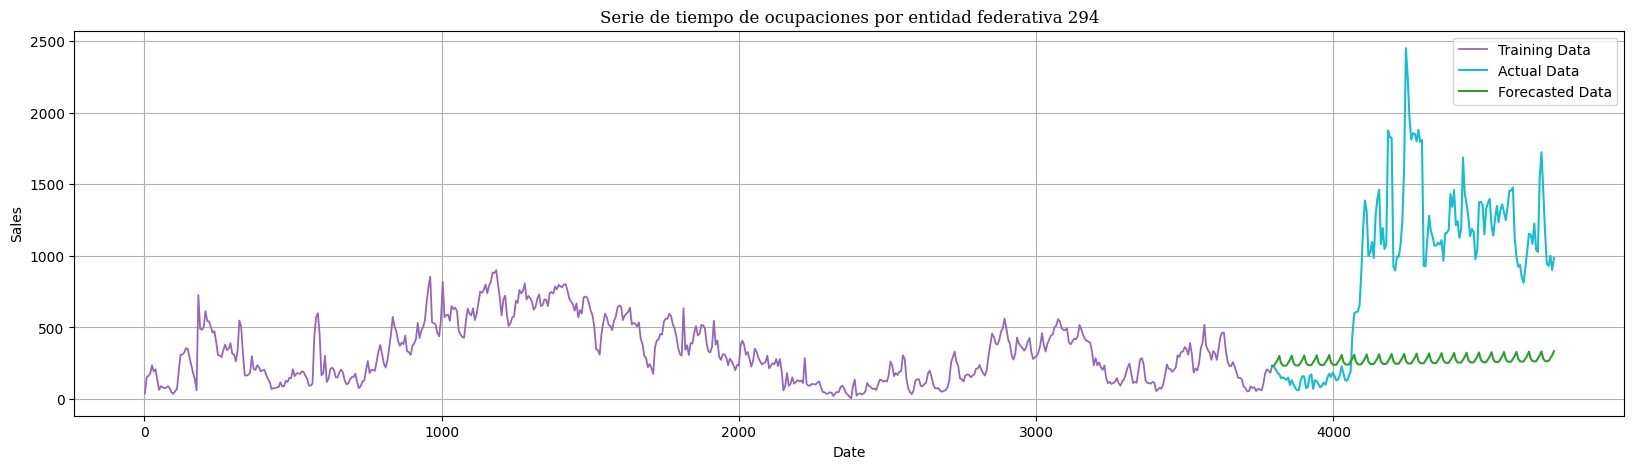

R-squared: -1.303725391503873
Root Mean Squared Error (RMSE): 865.0925590491175
Mean Absolute Percent Error: 0.8358738786371266
Processing state: 253
(1507, 9)
Train size: 632, Test size: 159


22:51:42 - cmdstanpy - INFO - Chain [1] start processing
22:51:42 - cmdstanpy - INFO - Chain [1] done processing


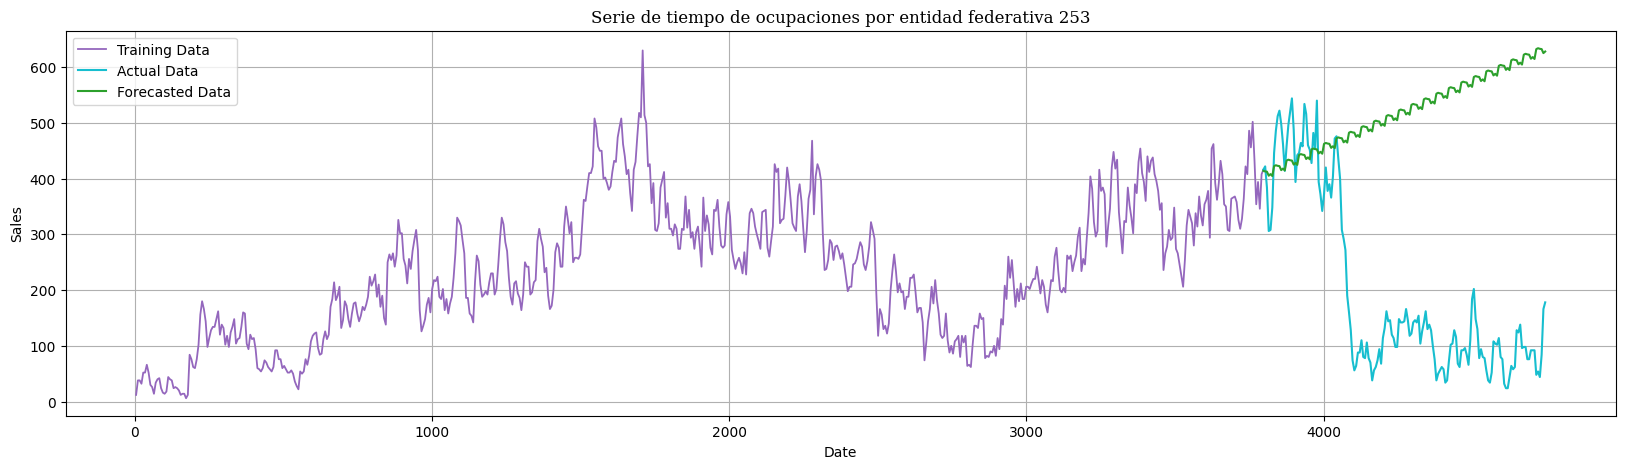

R-squared: -4.943153319995189
Root Mean Squared Error (RMSE): 388.5725518405544
Mean Absolute Percent Error: 4.303661744061847
Processing state: 173
(1507, 9)
Train size: 632, Test size: 159


22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:44 - cmdstanpy - INFO - Chain [1] done processing


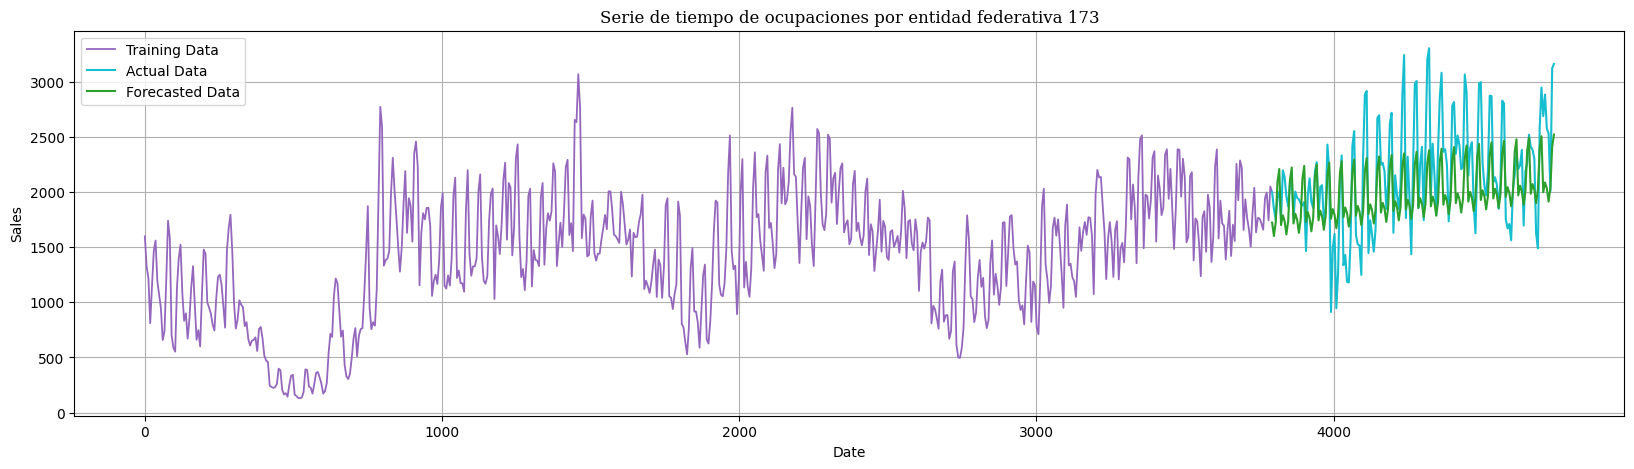

R-squared: 0.37360875350223055
Root Mean Squared Error (RMSE): 387.7297239125428
Mean Absolute Percent Error: 0.15095259979835776


In [28]:

for estado in estados:
    print(f"Processing state: {estado}")
    reservaciones = ocupaciones[ocupaciones['ID_Entidad_Fed'] == estado].copy()
    print(reservaciones.shape)
    df = reservaciones[['Fecha_hoy','num_adu']]
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])
    df['cap'] = 400000000.0  # upper bound
    df['floor'] = 0.0  # optional lower bound (default is 0)
    # Select df until 'Fecha_hoy' < '2023-01-01'
    df= df[df['ds'] < '2023-01-01']
    train_size = int(len(df) * 0.8)
    train, test = df[0:train_size], df[train_size:len(df)]
    print(f'Train size: {len(train)}, Test size: {len(test)}')
    model = Prophet(growth='linear',holidays=mexican_holidays)
    model.fit(train)
    future = test[['ds']]  # Use the actual dates from your test set
    future['cap'] = 400000000.0  # upper bound
    future['floor'] = 0.0
    forecast = model.predict(future)
    # Compare predicted 'yhat' to actual 'y'
    y_true = test['y'].values
    y_pred = forecast['yhat'].values
    #Plot config
    font_name = "Serif"

    graph_forecast =pd.DataFrame({
        
        'yhat': forecast['yhat'],
    })
    graph_forecast.index = test.index

    # Create a plot to compare the forecast with the actual test data
    plt.figure(figsize=(20,5))
    plt.plot(df[0:train_size+1]['y'],linewidth=1.3, c='tab:purple', label='Training Data')
    plt.plot(test['y'], label='Actual Data', color='tab:cyan')
    plt.plot(graph_forecast, label='Forecasted Data', color='tab:green')
    plt.title(f'Serie de tiempo de ocupaciones por entidad federativa {estado}', fontname=font_name)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

    residuals = y_true - y_pred
    r_2 = r2_score(test['y'], y_pred)
    print('R-squared:', r_2)
    rmse = mean_squared_error(test['y'], y_pred)**0.5
    print('Root Mean Squared Error (RMSE):', rmse)
    print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['y'])),len(residuals)))
    joblib.dump(model, '../models/prophet_model_numadu_' + str(estado) + '.pkl')
